# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [18]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0  Device: cpu


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [19]:
batch_size = 32 #批处理大小

#下载数据集
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())
#加载数据集
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

设置随机种子防止保证每次随机的样本都是一致的

In [29]:
import random
# 设置随机种子
# 固定shuffle随机数种子以及cpu等backend算法
seed = 10
random.seed(seed)
torch.manual_seed(seed)  # 为CPU设置种子用于生成随机数，以使得结果是确定的   　　
torch.backends.cudnn.deterministic = True

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [30]:
#读取loader中的张量大小
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

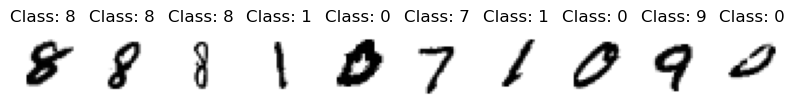

In [31]:
#显示MNIST图片
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)
    
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [33]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [63]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

def validate(loss_vector, accuracy_vector):
    #补充ROC曲线
    model.eval()
    val_loss, correct = 0, 0

    score_list = [] #存储预测得分
    label_list = [] #存储真实标签
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        score_temp = output # (batchsize, nclass)
        score_list.extend(score_temp.detach().cpu().numpy())
        label_list.extend(target.cpu().numpy())
    '''
    num_class = 10
    score_array = np.array(score_list)
    # 将label转换成onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_class)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)
    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

    # 调用sklearn库，计算每个类别对应的fpr和tpr
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(num_class):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    # Finally average it and compute AUC
    mean_tpr /= num_class
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

    plt.figure()
    lw = 2
    plt.plot(fpr_dict["micro"], tpr_dict["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr_dict["macro"], tpr_dict["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc_dict[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.savefig('set113_roc.jpg')
    plt.show()
    '''

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [65]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.809913
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.063828
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.949484
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.831192
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.071265
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.729847
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.813977
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.695589
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.348120
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.564770

Validation set: Average loss: 0.9047, Accuracy: 8129/10000 (81%)

CPU times: total: 1min 1s
Wall time: 16 s


Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

Text(0.5, 1.0, 'validation accuracy')

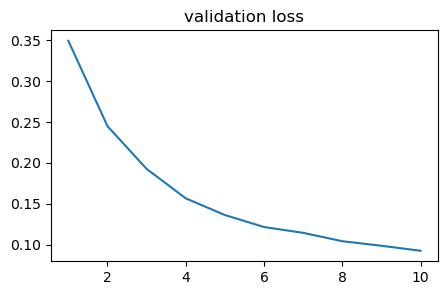

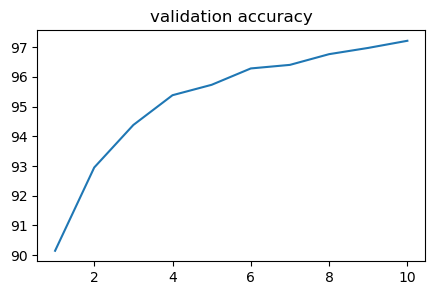

In [26]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.

查看迭代次数对于Accuracy的影响

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.008579
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.019733
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.024307
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.104952
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.083351
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.016213
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.008218
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.026545
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.201235
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.019565

Validation set: Average loss: 0.0673, Accuracy: 9810/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.012615
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.057322
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.009886
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.009098
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.024400
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.118904
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.036838
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.060107
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.00

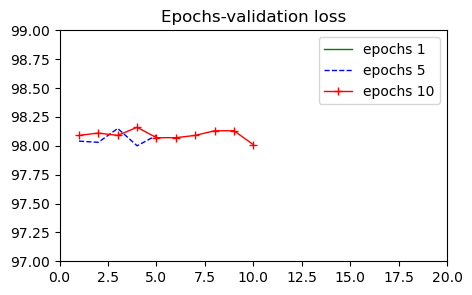

CPU times: total: 17min 31s
Wall time: 5min 11s


In [39]:
%%time
#查看迭代次数对于Accuracy的影响
plt.figure(figsize=(5,3))
for style, width, epochs in (('g-',1,1),('b--',1,5),('r-+',1,10)):
    lossv, accv = [], []
    for epoch in range(1, epochs + 1):
        train(epoch)
        validate(lossv, accv)
    plt.plot(np.arange(1,epochs+1), accv,style,label='epochs '+str(epochs),linewidth=width)

plt.title('Epochs-validation accuracy')
plt.axis([0,20,97,99])
plt.legend()
plt.show()

查看学习率对于Accuracy的影响

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.174515
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.048602
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.004325
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.003944
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.015827
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.008012
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.028821
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.039416
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.149144
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.199901

Validation set: Average loss: 0.0685, Accuracy: 9822/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.081008
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.003520
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003024
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.191712
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.005893
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.009242
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.020183
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.083341
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.15

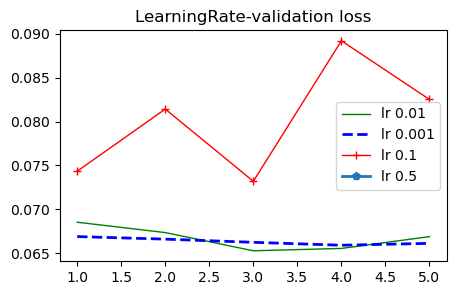

CPU times: total: 16min 21s
Wall time: 4min 8s


In [44]:
%%time
#查看迭代次数对于Accuracy的影响
epochs = 5

plt.figure(figsize=(5,3))
for style, width, lr in (('g-',1,0.01),('b--',2,0.001),('r-+',1,0.1),('p-',2,0.5)):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    lossv, accv = [], []
    for epoch in range(1, epochs + 1):
        train(epoch)
        validate(lossv, accv)
    plt.plot(np.arange(1,epochs+1), lossv,style,label='lr '+str(lr),linewidth=width)

plt.title('LearningRate-validation loss')
plt.legend()
plt.show()

选择不同的optim优化策略

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.449996
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.521170
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.420822
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.470717
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.508175
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.386823
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.466362
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.540472
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.548314
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.177765

Validation set: Average loss: 0.2695, Accuracy: 9374/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.380863
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.304911
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.264937
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.292426
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.827498
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.466476
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.534969
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.352522
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.30

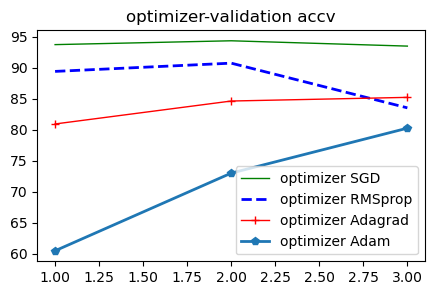

CPU times: total: 11min 9s
Wall time: 2min 57s


In [62]:
%%time
# 修改尝试不同的优化器 
epochs = 3

plt.figure(figsize=(5,3))
for style, width,title,optimizer in (('g-',1,'SGD',torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)),('b--',2,'RMSprop',torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.5)),('r-+',1,'Adagrad',torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0,weight_decay=0, initial_accumulator_value=0)),('p-',2,'Adam',torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.99)))):
    optimizer = optimizer
    criterion = nn.CrossEntropyLoss()
    lossv, accv = [], []
    for epoch in range(1, epochs + 1):
        train(epoch)
        validate(lossv, accv)
    plt.plot(np.arange(1,epochs+1), accv,style,label='optimizer '+str(title),linewidth=width)

plt.title('optimizer-validation accv')
plt.legend()
plt.show()

增加一层隐藏层看是否对结果有优化

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        #增加一层
        self.fc3 = nn.Linear(80,60)
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(60,10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        #增加一层
        x = F.relu(self.fc3(x))
        x = self.fc3_drop(x)   # [32, 10]
        return F.log_softmax(self.fc4(x), dim=1)
    
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=60, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=60, out_features=10, bias=True)
)


In [48]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330074
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.296006
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.245609
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.043406
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.485219
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.138627
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.028280
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.836121
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.758662
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.688553

Validation set: Average loss: 0.4010, Accuracy: 8890/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.475582
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.681139
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.709046
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.517130
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.621583
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.978258
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.366586
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.489570
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.32

Text(0.5, 1.0, 'validation accuracy')

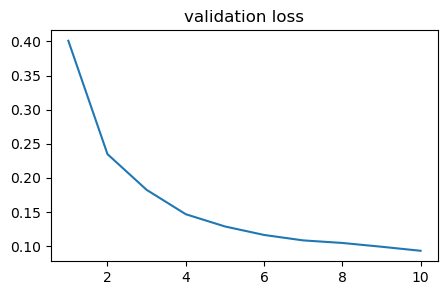

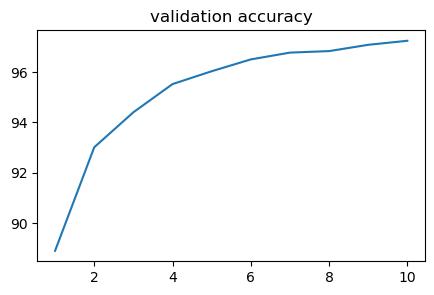

In [49]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')